# Example 2 - Pine Island Glacier

This notebook provides an example of a typical ISSM workflow to complete the following:

1. Build and parameterise an ISSM model
2. Conduct a basal friction inversion
3. Run a transient stress balance simulation

In [1]:
import os
import pyissm
import datapool as dp
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# TODO:

- Crop data to mesh extent before interpolation inside `pyissm.data.interp.xr_to_mesh`.

## Setup your modelling environment

Some High-Performance Comupting (HPC) infrastructure places limitations on user read/write permissions. To make this notebook flexible for all users, please define some variables used internally in this notebook. The following variables must be defined in the cell below:

- `tutorial_dir = <PATH_TO_NOTEBOOK>` where this notebook is located. By default, this is assumed to be `~/pyISSM/tutorials`
- `tutorial_asset_dir = <PATH_TO_ASSETS>` where all tutorials assets are located. By default, this is assumed to be `~/pyISSM/tutorials/assets`
- `execution_dir = <PATH_TO_DIRECTORY>` where model files will be saved. You must have `rwx` permissions for this directory. By default, this is assumed to be `~/pyISSM/tutorials/models`

NOTE: `execution_dir` must be different from the current working directory of your Python kernel.

In [2]:
tutorial_dir = str(Path.home() / 'pyISSM' / 'tutorials')
asset_dir = tutorial_dir + '/assets'
execution_dir = tutorial_dir + '/models'

# Check that execution directory exists. If not, create it
if not os.path.isdir(execution_dir):
    os.mkdir(execution_dir)

---
## 1. Model mesh

In this example, we first generate a uniform mesh with a resolution of 10 km. We then refine this mesh based on the observed velocity field using anisotropic mesh refinement. At each step, we plot the mesh and velocity field.

In [3]:
# Define mesh parameters
hinit = 10000
hmax = 40000
hmin = 5000
gradation = 1.7
err = 8

# Generate initial uniform mesh
md = pyissm.model.mesh.bamg(pyissm.model.Model(),
                            domain = asset_dir + '/Exp/PIG_DomainOutline.exp',
                            hmax = hinit)

Text(0.5, 1.0, 'Initial uniform model mesh')

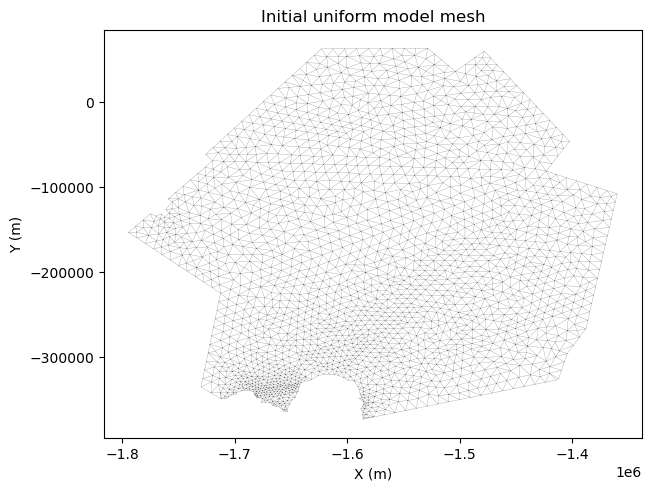

In [4]:
# Plot initial uniform mesh
fig, ax = pyissm.plot.plot_mesh2d(md)
ax.set_title('Initial uniform model mesh')

Here, we load the velocity dataset and interpolate this onto the model mesh. Here we use the ACCESS Cryosphere Data Pool to access the data on NCI Gadi. If running this notebook locally, simply load the dataset using `xarray`.

In [5]:
# Load velocity
catalog = dp.catalog.DataCatalog()
velocity = catalog.load_dataset('measures_its_live_regional_glacier_and_ice_sheet_surface_velocities', version = 'v2', subdataset = 'RGI19A', static = True)

# Crop velocity to mesh extent for faster interpolation
x_min = np.min(md.mesh.x)
x_max = np.max(md.mesh.x)
y_min = np.min(md.mesh.y)
y_max = np.max(md.mesh.y)

vel = velocity.sel(
    x=slice(x_min, x_max),
    y=slice(y_max, y_min)
)

# Assign velocity to model
md.inversion.vx_obs = pyissm.data.interp.xr_to_mesh(vel, 'vx', md.mesh.x, md.mesh.y)
md.inversion.vy_obs = pyissm.data.interp.xr_to_mesh(vel, 'vy', md.mesh.x, md.mesh.y)
md.inversion.vel_obs = np.sqrt(md.inversion.vx_obs**2 + md.inversion.vy_obs**2)

Construction of a mesh from a given geometry


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/_task_spec.py:758: FutureWarning: In a future version, xarray will not decode the variable 'dt_max' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  return self.func(*new_argspec, **kwargs)


Text(0.5, 1.0, 'Observed velocity')

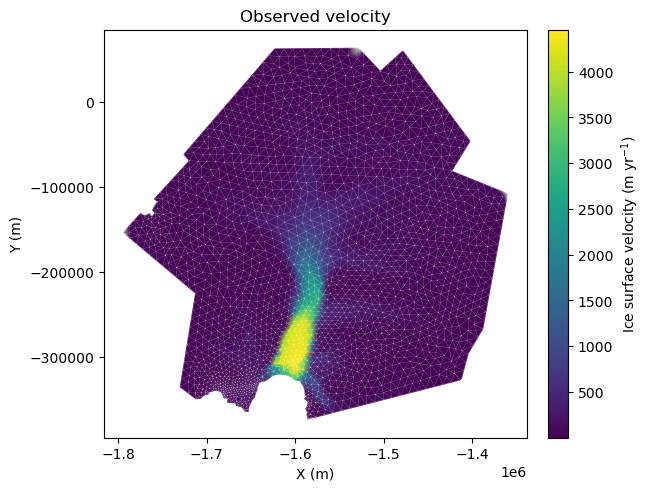

In [6]:
# Visualise velocity
fig, ax = pyissm.plot.plot_model_field(md,
                                       md.inversion.vel_obs,
                                       show_mesh = True,
                                       mesh_kwargs = {'color': 'white'},
                                       show_cbar = True,
                                       cbar_kwargs = {'label': 'Ice surface velocity (m yr$^{-1}$)'})
ax.set_title('Observed velocity')

In [7]:
## Adapt the mesh based on the velocity
md = pyissm.model.mesh.bamg(md,
                            hmax = hmax,
                            hmin = hmin,
                            gradation = gradation,
                            field = md.inversion.vel_obs,
                            err = err)

Text(0.5, 1.0, 'Refined model mesh')

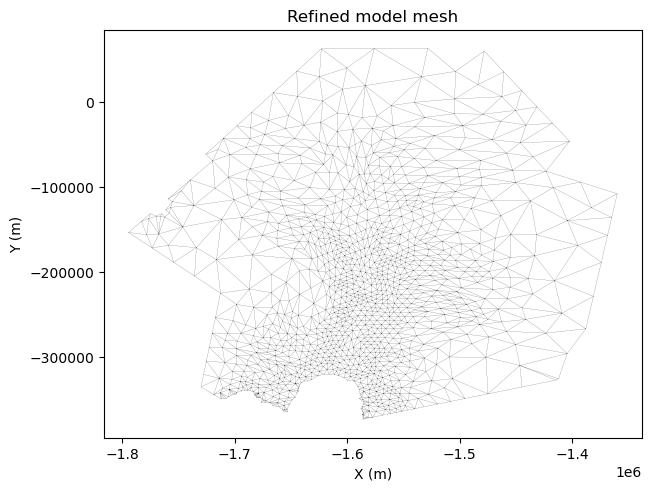

In [8]:
fig, ax = pyissm.plot.plot_mesh2d(md)
ax.set_title('Refined model mesh')

In [9]:
## Save the model
pyissm.model.io.save_model(md, tutorial_dir + '/ex2_PIG_mesh.nc')